In [155]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [156]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
from tensorflow import keras

# Data

In [5]:
df = pd.read_csv('MRTSSM448USN.csv', parse_dates = True, index_col = 'DATE')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341 entries, 1992-01-01 to 2020-05-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   MRTSSM448USN  341 non-null    int64
dtypes: int64(1)
memory usage: 5.3 KB


In [7]:
df.head(5)

,MRTSSM448USN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [8]:
df.columns = ['Sales']

In [9]:
# last 7 values look like outliers
df = df[:334] 

<AxesSubplot:xlabel='DATE'>

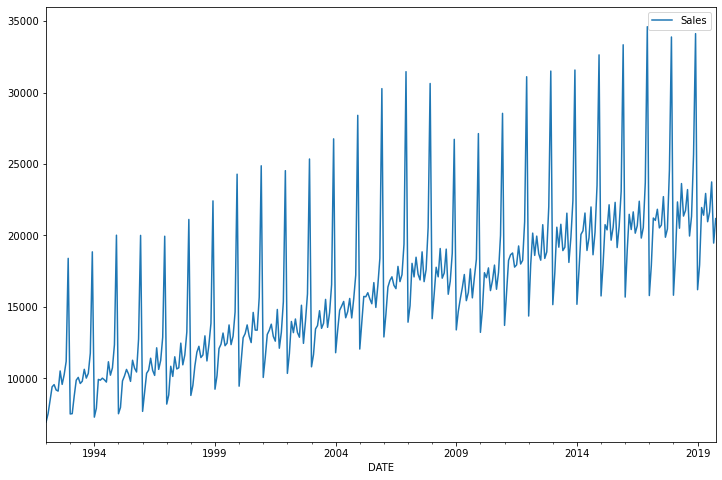

In [10]:
df.plot(figsize = (12,8))

In [11]:
test_size = 18
test_ind = len(df) - test_size

In [12]:
train = df.iloc[:test_ind]
test  = df.iloc[test_ind:]

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler()

In [16]:
scaled_train = scaler.transform(train)

In [17]:
scaled_test  = scaler.transform(test)

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size = 1)

In [20]:
X, y = generator[0]

In [21]:
X

array([[[0.        ],
        [0.02117588],
        [0.0555415 ],
        [0.08900372],
        [0.09467712],
        [0.08108987],
        [0.0782351 ],
        [0.12918729],
        [0.09521917],
        [0.11982799],
        [0.15354316],
        [0.41401366]]])

In [22]:
y

array([[0.02038088]])

# Model

In [23]:
n_features = 1

In [24]:
model = keras.models.Sequential([
    keras.layers.LSTM(100, activation = 'relu', input_shape = (length, n_features)),
    keras.layers.Dense(1)
])

In [25]:
model.compile(optimizer='adam', loss = 'mse')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [29]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size = 1)

In [30]:
model.fit_generator(generator, epochs = 20, validation_data = validation_generator, callbacks = [early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0246 - val_loss: 0.0091
Epoch 2/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0199 - val_loss: 0.0089
Epoch 3/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0131 - val_loss: 0.0413
Epoch 4/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0065 - val_loss: 9.4742e-04
Epoch 5/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 6/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0030 - val_loss: 0.0042


In [31]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

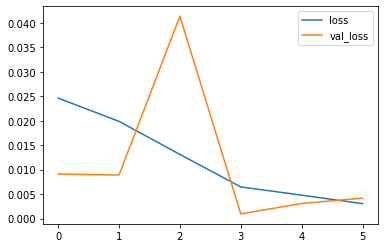

In [32]:
losses.plot()

In [33]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [34]:
true_pred = scaler.inverse_transform(test_predictions)

In [110]:
true_pred.reshape(true_pred.shape[0],)

array([23041.56034774, 22036.13965285, 22288.82056344, 23988.37976193,
       21671.50964516, 22342.85454661, 26316.35390431, 37043.98899651,
       18611.92503637, 20533.90947974, 23657.03873891, 22314.46604621,
       24523.34572029, 23720.40030152, 24039.56846225, 25616.31370676,
       23603.06413555, 24431.27566606])

In [35]:
test['Pred'] = true_pred

C:\Users\dixq1\anaconda3\envs\exam_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [111]:
tf.keras.metrics.mean_absolute_error(np.array(test['Sales']), true_pred.reshape(true_pred.shape[0],)).numpy()

1805.8774453732703

<AxesSubplot:xlabel='DATE'>

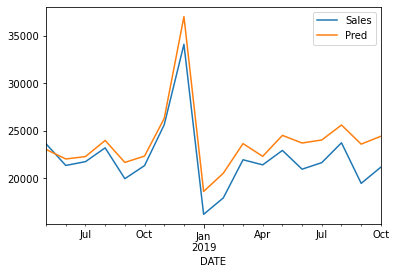

In [36]:
test.plot()

In [37]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [38]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size = 1)

In [39]:
model_full = keras.models.Sequential([
    keras.layers.LSTM(100, activation = 'relu', input_shape=(length, n_features)),
    keras.layers.Dense(1)
])

In [40]:
model_full.compile(loss = 'mse', optimizer = 'adam')

In [41]:
model_full.fit_generator(generator, epochs = 20, validation_data = validation_generator, callbacks = [early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 322 steps, validate for 6 steps
Epoch 1/20
322/322 [==============================] - 3s 10ms/step - loss: 0.0272 - val_loss: 0.0038
Epoch 2/20
322/322 [==============================] - 2s 7ms/step - loss: 0.0187 - val_loss: 0.0049
Epoch 3/20
322/322 [==============================] - 2s 7ms/step - loss: 0.0134 - val_loss: 0.0130


In [42]:
test_predictions = []

periods = 12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [43]:
true_pred = scaler.inverse_transform(test_predictions)

In [44]:
test['Pred_Full'] = true_pred

C:\Users\dixq1\anaconda3\envs\exam_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='DATE'>

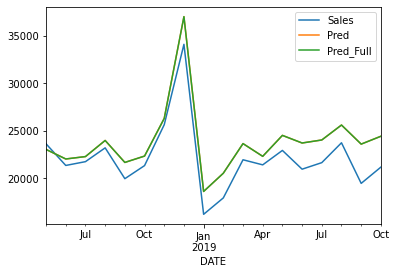

In [45]:
test.plot()

# Model with Window

In [203]:
window_size = 12
batch_size = 5
shuffle_buffer_size = 100

In [204]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [205]:
(train['Sales'].max() // 1000 + 1) * 1000

35000

In [206]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(np.array(train['Sales']), window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * (train['Sales'].max() // 1000 + 1) * 1000)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
61/61 [==============================] - 5s 76ms/step - loss: 3502.5484 - mae: 3492.4897
Epoch 2/100
61/61 [==============================] - 0s 6ms/step - loss: 4040.1878 - mae: 4046.3701
Epoch 3/100
61/61 [==============================] - 0s 7ms/step - loss: 3968.6254 - mae: 3976.0007
Epoch 4/100
61/61 [==============================] - 0s 6ms/step - loss: 4179.2836 - mae: 4186.4233
Epoch 5/100
61/61 [==============================] - 0s 6ms/step - loss: 3765.4457 - mae: 3773.7295
Epoch 6/100
61/61 [==============================] - 0s 6ms/step - loss: 3843.6945 - mae: 3843.9453
Epoch 7/100
61/61 [==============================] - 0s 6ms/step - loss: 4352.8776 - mae: 4359.7158
Epoch 8/100
61/61 [==============================] - 0s 6ms/step - loss: 3659.0536 - mae: 3664.1833
Epoch 9/100
61/61 [==============================] - 0s 6ms/step - loss: 4089.4477 - mae: 4090.1492
Epoch 10/100
61/61 [==============================] - 0s 6ms/step - loss: 3959.6625 - mae: 3964.775

61/61 [==============================] - 0s 6ms/step - loss: 117854.0116 - mae: 117980.0547
Epoch 82/100
61/61 [==============================] - 0s 6ms/step - loss: 162973.8855 - mae: 162813.0156
Epoch 83/100
61/61 [==============================] - 0s 6ms/step - loss: 121563.0993 - mae: 121609.9453
Epoch 84/100
61/61 [==============================] - 0s 6ms/step - loss: 184376.1060 - mae: 183610.0156
Epoch 85/100
61/61 [==============================] - 0s 6ms/step - loss: 235833.2277 - mae: 235179.2656
Epoch 86/100
61/61 [==============================] - 0s 6ms/step - loss: 245516.1603 - mae: 245578.8125
Epoch 87/100
61/61 [==============================] - 0s 6ms/step - loss: 191014.3308 - mae: 190081.0469
Epoch 88/100
61/61 [==============================] - 0s 6ms/step - loss: 255387.6588 - mae: 254815.7656
Epoch 89/100
61/61 [==============================] - 0s 6ms/step - loss: 288375.0423 - mae: 289281.9688
Epoch 90/100
61/61 [==============================] - 0s 6ms/step - 

In [133]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

In [134]:
forecast = []
for time in range(len(np.array(df['Sales'])) - window_size):
  forecast.append(model.predict(np.array(df['Sales'])[time:time + window_size][np.newaxis]))

forecast = forecast[test_ind-window_size:]
results = np.array(forecast)[:, 0, 0]

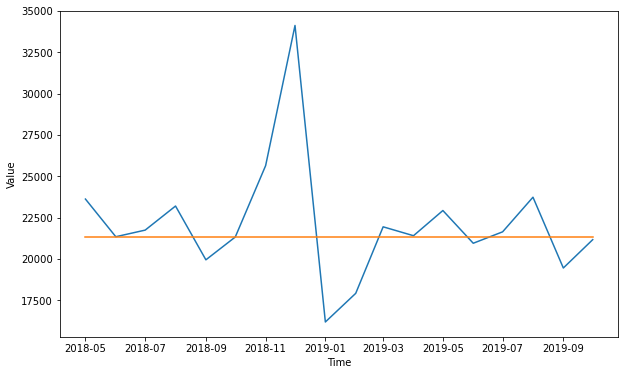

In [135]:
plt.figure(figsize=(10, 6))

time_valid = df.index[test_ind:] 

plot_series(time_valid, np.array(test['Sales']))
plot_series(time_valid, results)

In [118]:
tf.keras.metrics.mean_absolute_error(np.array(test['Sales']), results).numpy()

5621.58